In [283]:
import numpy as np
import matplotlib.pyplot as plt

In [284]:
from loaders import clean_text_for_pattern_letter
from temp_text import template_str
input_str = clean_text_for_pattern_letter(template_str, out_len=500)
print(len(input_str))
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', '\'', '1']
print(f'{letters=}')

len(letters)=32
500
letters=['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ', '.', ',', '"', "'", '1']


In [285]:
def predict_train(input_str, letters, max_index:int = 4,):
    next_index: dict[str, int] = {}
    index_by_prev: dict[str, dict] = {}

    StatsDict: dict[str, dict] = {}

    for letter in letters:
        next_index[letter] = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]
        
        inp_index = next_index[inp]

        prev_index = next_index[prev_inp]

        stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
        StatsDict.setdefault(stats_key, {})

        next_inp = input_str[inp_idx + 1]
        StatsDict[stats_key].setdefault(next_inp, 0)

        StatsDict[stats_key][next_inp] += 1

        by_prev_key = prev_inp + str(prev_index) + ':' + inp
        index_by_prev.setdefault(by_prev_key, {})
        index_by_prev[by_prev_key].setdefault(inp_index, 0)
        index_by_prev[by_prev_key][inp_index] += 1

        by_prev_key = prev_inp + str(0) + ':' + inp
        index_by_prev.setdefault(by_prev_key, {})
        index_by_prev[by_prev_key].setdefault(inp_index, 0)
        index_by_prev[by_prev_key][inp_index] += 1
        
        next_index[prev_inp] += 1
        if next_index[prev_inp] > max_index:
            next_index[prev_inp] = 1
    
    return StatsDict, index_by_prev

In [343]:
def predict(input_str, TF:list, StatsDict:dict, index_by_prev:dict, max_index, err = 0,):
    prev_index_l = [x for x in range(1, max_index+1)]

    output = []

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]
        
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = prev_inp + str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index:
                max_key_d = 1
            
            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)
            # B B {'B': 1} [3] {3: 1} [3] False
            output.append(max_key)

        prev_index_l = list(index_d.keys())
        
        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)
    
    output.insert(0, input_str[1])
    
    return TF, err, output

In [344]:
# train
max_index_L1 = 4

index_by_prev_L1: dict[str, dict] = {}
StatsDict_L1: dict[str, dict] = {}

StatsDict, index_by_prev_L1 = predict_train(letters=letters, input_str=input_str, max_index=max_index_L1)

In [345]:
for sdk, sdv in index_by_prev_L1.items():
    print(sdk, sdv)
    print('')

t1:h {1: 2}

t0:h {1: 4, 2: 2, 3: 3, 4: 2}

h1:e {1: 1, 4: 3}

h0:e {1: 1, 3: 3, 4: 5, 2: 4}

e1:  {1: 2, 4: 1}

e0:  {1: 6, 3: 4, 4: 4, 2: 3}

 1:s {1: 1}

 0:s {1: 1, 3: 2, 4: 1, 2: 2}

s1:k {1: 1}

s0:k {1: 1}

k1:y {1: 1}

k0:y {1: 1}

y1:  {2: 1}

y0:  {2: 1, 1: 2, 3: 1}

 2:a {1: 1}

 0:a {1: 3, 3: 5, 2: 2, 4: 2}

a1:b {1: 1}

a0:b {1: 1}

b1:o {1: 1}

b0:o {1: 1, 2: 2}

o1:v {1: 1}

o0:v {1: 1}

v1:e {2: 1}

v0:e {2: 1, 3: 2, 1: 1}

e2:  {3: 3, 2: 1, 1: 2}

 3:t {2: 2, 3: 1, 4: 1}

 0:t {2: 5, 4: 3, 1: 3, 3: 3}

t2:h {2: 2, 1: 2, 4: 1}

h2:e {3: 2, 2: 2}

e3:  {4: 2, 1: 1, 2: 2}

 4:p {1: 1}

 0:p {1: 2, 4: 1}

p1:o {2: 1}

p0:o {2: 1}

o2:r {1: 2}

o0:r {1: 3, 2: 2, 4: 1}

r1:t {3: 1}

r0:t {3: 1}

t3:  {1: 1}

t0:  {1: 2, 4: 1}

 1:w {1: 1}

 0:w {1: 1, 2: 2, 4: 2, 3: 2}

w1:a {2: 1}

w0:a {2: 3, 1: 2}

a2:s {2: 2, 1: 1}

a0:s {2: 2, 1: 3, 3: 3}

s2:  {2: 1, 4: 1}

s0:  {2: 2, 4: 7, 1: 2, 3: 3}

 2:t {4: 1, 2: 1, 3: 2}

t4:h {3: 2, 4: 1}

h3:e {4: 2, 2: 1}

e4:  {3: 1, 1: 1, 4

In [346]:
for sdk, sdv in StatsDict.items():
    print(sdk, sdv)
    print('')

t1:h1 {'e': 2}

h1:e1 {' ': 1}

e1: 1 {'s': 1, 'd': 1}

 1:s1 {'k': 1}

s1:k1 {'y': 1}

k1:y1 {' ': 1}

y1: 2 {'a': 1}

 2:a1 {'b': 1}

a1:b1 {'o': 1}

b1:o1 {'v': 1}

o1:v1 {'e': 1}

v1:e2 {' ': 1}

e2: 3 {'t': 1, 's': 1, 'c': 1}

 3:t2 {'h': 2}

t2:h2 {'e': 2}

h2:e3 {' ': 2}

e3: 4 {'p': 1, 'f': 1}

 4:p1 {'o': 1}

p1:o2 {'r': 1}

o2:r1 {'t': 1, 'd': 1}

r1:t3 {' ': 1}

t3: 1 {'w': 1}

 1:w1 {'a': 1}

w1:a2 {'s': 1}

a2:s2 {' ': 1, 'e': 1}

s2: 2 {'t': 1}

 2:t4 {'h': 1}

t4:h3 {'e': 1, 'i': 1}

h3:e4 {' ': 1, 'a': 1}

e4: 3 {'c': 1}

 3:c1 {'o': 1}

c1:o3 {'l': 1}

o3:l1 {'o': 1}

l1:o4 {'r': 1}

o4:r2 {' ': 2}

r2: 4 {'o': 1}

 4:o1 {'f': 1}

o1:f1 {' ': 1}

f1: 1 {'t': 1}

 1:t1 {'e': 1}

t1:e1 {'l': 1, 's': 1}

e1:l2 {'e': 1}

l2:e2 {'v': 1}

e2:v2 {'i': 1, 'e': 1}

v2:i1 {'s': 1}

i1:s3 {'i': 1}

s3:i2 {'o': 1}

i2:o2 {'n': 1}

o2:n1 {',': 1, 'o': 1}

n1:,1 {' ': 1}

,1: 2 {'t': 1}

 2:t2 {'u': 1}

t2:u1 {'n': 1}

u1:n2 {'e': 1}

n2:e3 {'d': 1}

e3:d1 {' ': 1}

d1: 3 {'t': 1}



In [347]:
# predict
TF = []

TF, err, out_L1 = predict(input_str=input_str, TF=TF, StatsDict=StatsDict, index_by_prev=index_by_prev_L1, max_index=max_index_L1)

print(err, err / (len(input_str) / 100) )

e e {'e': 4} [1, 2, 4, 3] {1: 4, 2: 2, 4: 2, 3: 3} [1, 2, 3, 4] False
    {' ': 4, 'a': 1, 't': 1, 'r': 1} [1, 4, 3, 2] {1: 1, 4: 5, 3: 3, 2: 4} [1, 2, 4, 3] False
s s {'s': 2, 'd': 2, 'm': 1, 'c': 1} [1, 4, 3, 2] {1: 6, 4: 4, 3: 4, 2: 3} [1, 4, 3, 2] False
p k {'k': 1, 'a': 1, 'o': 1, 'p': 2, 'h': 1} [1, 4, 3, 2] {1: 1, 4: 1, 3: 2, 2: 2} [1, 4, 3, 2] False
y y {'y': 1} [1] {1: 1} [1, 4, 3, 2] False
    {' ': 1} [1] {1: 1} [1] False
a a {'a': 1} [2] {2: 1} [1] False
b b {'b': 1} [1] {1: 1} [2] False
o o {'o': 1} [1] {1: 1} [1] False
v v {'v': 1} [1] {1: 1} [1] False
e e {'e': 1} [1] {1: 1} [1] False
    {' ': 1} [2] {2: 1} [1] False
c t {'t': 1, 's': 1, 'c': 2, 'i': 1, 'f': 1} [3, 2, 1] {3: 3, 2: 1, 1: 2} [2] False
h h {'h': 2, 'o': 1, 'e': 1} [2, 3, 4, 1] {2: 4, 3: 3, 4: 3, 1: 1} [3, 2, 1] False
e e {'e': 4, 'r': 1} [2, 1, 4, 3] {2: 2, 1: 4, 4: 2, 3: 3} [2, 3, 4, 1] False
    {' ': 4, 'r': 1, 'a': 1, 't': 1} [3, 2, 1, 4] {3: 3, 2: 4, 1: 1, 4: 5} [2, 1, 4, 3] False
s p {'p': 1, 'f': 1,

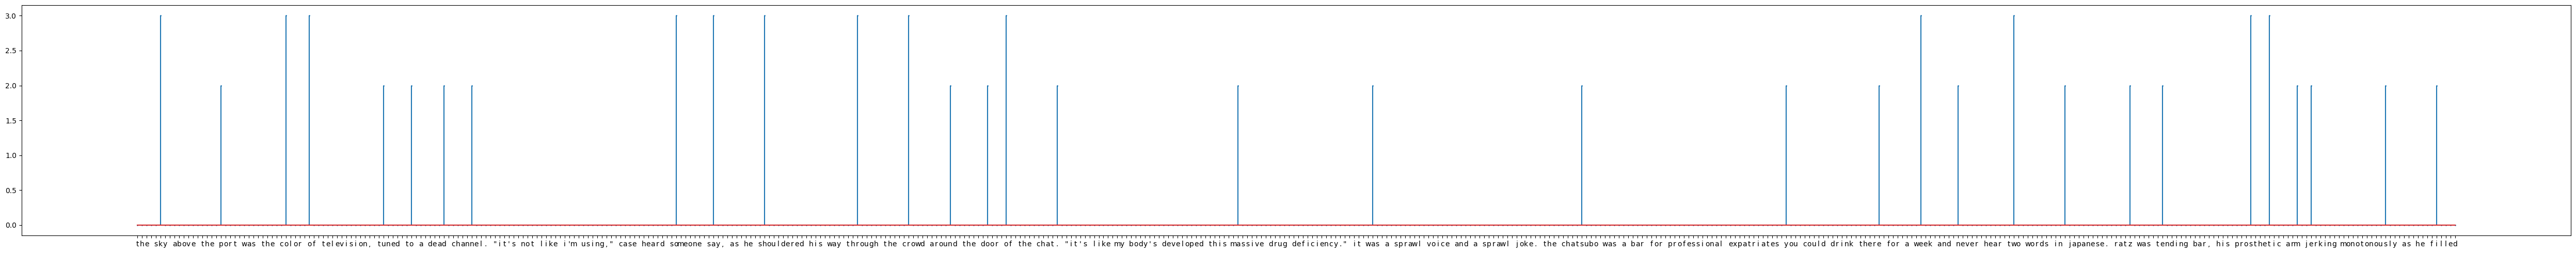

In [348]:
TF = np.array(TF, dtype=float)
# print(TF)
TF = np.pad(TF, (1, 1), constant_values=[1,1])
# print(TF)
TF = np.pad(TF, (1, 0))[:-1] - TF
# TF = TF - np.pad(TF, (1, 0))[:-1] 
# TF = np.pad(TF, (1, 0))[:-1] - TF
# TF = TF - np.pad(TF, (0, 1))[-1:]
# print(TF)
TF[np.where(TF < 0)] = 0
# TF = np.abs(TF)
TF[np.where(TF <= np.mean(TF[np.where(TF > 0)]))] = 0
# # TF[np.where(TF <= 0.5)] = 0
# print(TF.size, TF.max(), TF.min())

fig, axs = plt.subplots(1, 1, figsize=(50, 5), tight_layout=True)
# axs.plot(np.arange(TF.size), TF)
markerline, stemline, baseline, = axs.stem(np.arange(TF.size), TF)
plt.setp(markerline, markersize = 1)
axs.xaxis.set_ticks(np.arange(len(input_str)) ,input_str)
# axs.xaxis.grid(True)

plt.show()

In [349]:
upstream_inp: dict[int, list] = {}

temp_seq = []

for inp_idx, inp in enumerate(input_str):
    tf = TF[inp_idx]
    
    if tf > 0:
        upstream_inp.setdefault(inp_idx, temp_seq.copy())
        temp_seq.clear()

    temp_seq.append(inp)

for item, val in upstream_inp.items():
    print(item, val)
    
print(len(upstream_inp))

5 ['t', 'h', 'e', ' ', 's']
18 ['k', 'y', ' ', 'a', 'b', 'o', 'v', 'e', ' ', 't', 'h', 'e', ' ']
32 ['p', 'o', 'r', 't', ' ', 'w', 'a', 's', ' ', 't', 'h', 'e', ' ', 'c']
37 ['o', 'l', 'o', 'r', ' ']
53 ['o', 'f', ' ', 't', 'e', 'l', 'e', 'v', 'i', 's', 'i', 'o', 'n', ',', ' ', 't']
59 ['u', 'n', 'e', 'd', ' ', 't']
66 ['o', ' ', 'a', ' ', 'd', 'e', 'a']
72 ['d', ' ', 'c', 'h', 'a', 'n']
116 ['n', 'e', 'l', '.', ' ', '"', 'i', 't', "'", 's', ' ', 'n', 'o', 't', ' ', 'l', 'i', 'k', 'e', ' ', 'i', "'", 'm', ' ', 'u', 's', 'i', 'n', 'g', ',', '"', ' ', 'c', 'a', 's', 'e', ' ', 'h', 'e', 'a', 'r', 'd', ' ', 's']
124 ['o', 'm', 'e', 'o', 'n', 'e', ' ', 's']
135 ['a', 'y', ',', ' ', 'a', 's', ' ', 'h', 'e', ' ', 's']
155 ['h', 'o', 'u', 'l', 'd', 'e', 'r', 'e', 'd', ' ', 'h', 'i', 's', ' ', 'w', 'a', 'y', ' ', 't', 'h']
166 ['r', 'o', 'u', 'g', 'h', ' ', 't', 'h', 'e', ' ', 'c']
175 ['r', 'o', 'w', 'd', ' ', 'a', 'r', 'o', 'u']
183 ['n', 'd', ' ', 't', 'h', 'e', ' ', 'd']
187 ['o', 'o', 'r',

In [350]:
letters_dict: dict[str, int] = {}
for let_idx, letter in enumerate(letters):
    letters_dict.setdefault(letter, let_idx)

upstream_patterns = []

for upstream_letters in upstream_inp.values():
    upstream_pattern = np.zeros(len(letters))

    for letter in upstream_letters:
        pattern_idx = letters_dict.get(letter, 0)

        upstream_pattern[pattern_idx] = 1
    
    upstream_patterns.append(upstream_pattern)

upstream_patterns = np.array(upstream_patterns)

for up_ptr in upstream_patterns:
    print(up_ptr.astype(int).tolist())

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0]
[0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 1, 0, 0, 1, 0, 0,

In [351]:
layer_size = 16

I = np.zeros(upstream_patterns.shape[1])
O = np.zeros(layer_size)
W = np.ones((O.size, I.size))
Trace = np.zeros((O.size, I.size))
print('W', W.shape, W.max(), W.min(), np.median(W))

k = 1
push_delta = 0.4

prec = 1e-30

epoch_cnt = 100
eps0 = 0.02

eps = 0.05
rate_drop = 0.0

AVG_O = np.zeros(O.shape)
AVG_O_CNT = np.zeros(O.shape)

samples_idx = np.arange(upstream_patterns.shape[0])

for epoch_idx in range(epoch_cnt):
    np.random.shuffle(samples_idx)

    for i_idx in samples_idx:
        I = upstream_patterns[i_idx]

        # infer
        O = np.dot(W, I)

        # train
        winner_ids = np.argsort(O)[::-1][:1+k]
        winner = winner_ids[0]
        loosers = winner_ids[1:1+k]

        # update
        W[winner] = (1 - eps) * W[winner] + eps * (I - 0.5) + Trace[winner]*eps
        W[winner] = np.clip(W[winner], -1, 1)

        # W[loosers] = (1 - eps) * W[loosers] + (eps * (I - 0.5) * -push_delta) + Trace[loosers]*eps
        # W[loosers] = np.clip(W[loosers], -1, 1)

        # update Trace
        rate_Trace = np.zeros(I.shape)
        rate_Trace[(I > 0.5)] = 0.3
        rate_Trace[(I < 0.5)] = -0.001

        dTrace = np.zeros(W.shape)
        dTrace[winner] = rate_Trace
        Trace += dTrace
        Trace = np.clip(Trace, 0, 1)

        eps -= eps * rate_drop

print('W', W.shape, W.max(), W.min(), np.median(W))

W (16, 32) 1.0 1.0 1.0
W (16, 32) 1.0 -0.4999999979578569 -0.3809615384619588


In [352]:
SL_symbols = [x.capitalize() for x in letters][:layer_size]
print(len(SL_symbols))

SLSymbolDict = {}

SL_symbols_d = {}
for idx, val in enumerate(SL_symbols):
    SL_symbols_d.setdefault(val + ':' + str(idx), 0)

upstream_inp_keys = list(upstream_inp.keys())

for upstr_idx, up_ptr in enumerate(upstream_patterns):
    O = np.dot(W, up_ptr)

    winner = np.argmax(O)
    print(SL_symbols[winner])

    sls = SL_symbols[winner]
    sls_key = upstream_inp_keys[upstr_idx]
    SLSymbolDict.setdefault(sls_key, sls)
    
    SL_symbols_d[SL_symbols[winner] + ':' + str(winner)] += 1

print(len(SL_symbols_d))
for key, val in SL_symbols_d.items():
    print(key, val)

print(SLSymbolDict)

16
I
M
I
H
O
E
G
K
K
L
D
H
C
F
K
F
C
M
E
I
H
J
H
N
A
L
I
P
G
I
E
B
J
D
16
A:0 1
B:1 1
C:2 2
D:3 2
E:4 3
F:5 2
G:6 2
H:7 4
I:8 5
J:9 2
K:10 3
L:11 2
M:12 2
N:13 1
O:14 1
P:15 1
{5: 'I', 18: 'M', 32: 'I', 37: 'H', 53: 'O', 59: 'E', 66: 'G', 72: 'K', 116: 'K', 124: 'L', 135: 'D', 155: 'H', 166: 'C', 175: 'F', 183: 'K', 187: 'F', 198: 'C', 237: 'M', 266: 'E', 311: 'I', 355: 'H', 375: 'J', 384: 'H', 392: 'N', 404: 'A', 415: 'L', 429: 'I', 436: 'P', 455: 'G', 459: 'I', 465: 'E', 468: 'B', 484: 'J', 495: 'D'}


In [353]:
sl_input = list(SLSymbolDict.values())
print(sl_input)

['I', 'M', 'I', 'H', 'O', 'E', 'G', 'K', 'K', 'L', 'D', 'H', 'C', 'F', 'K', 'F', 'C', 'M', 'E', 'I', 'H', 'J', 'H', 'N', 'A', 'L', 'I', 'P', 'G', 'I', 'E', 'B', 'J', 'D']


In [354]:
# SL train
max_index_L2 = 4

StatsDict_L2, index_by_prev_L2 = predict_train(input_str=sl_input, letters=SL_symbols, max_index=max_index_L2)

In [355]:
for sdk, sdv in StatsDict_L2.items():
    print(sdk, sdv)
    print('')

I1:M1 {'I': 1}

M1:I2 {'H': 1}

I2:H1 {'O': 1}

H1:O1 {'E': 1}

O1:E1 {'G': 1}

E1:G1 {'K': 1}

G1:K1 {'K': 1}

K1:K1 {'L': 1}

K2:L1 {'D': 1}

L1:D1 {'H': 1}

D1:H2 {'C': 1}

H2:C1 {'F': 1}

C1:F1 {'K': 1}

F1:K3 {'F': 1}

K3:F2 {'C': 1}

F2:C2 {'M': 1}

C2:M2 {'E': 1}

M2:E2 {'I': 1}

E2:I3 {'H': 1}

I3:H3 {'J': 1}

H3:J1 {'H': 1}

J1:H4 {'N': 1}

H4:N1 {'A': 1}

N1:A1 {'L': 1}

A1:L2 {'I': 1}

L2:I4 {'P': 1}

I4:P1 {'G': 1}

P1:G2 {'I': 1}

G2:I1 {'E': 1}

I1:E3 {'B': 1}

E3:B1 {'J': 1}

B1:J2 {'D': 1}



In [356]:
for sdk, sdv in index_by_prev_L2.items():
    print(sdk, sdv)
    print('')

I1:M {1: 1}

I0:M {1: 1}

M1:I {2: 1}

M0:I {2: 1}

I2:H {1: 1}

I0:H {1: 1, 3: 1}

H1:O {1: 1}

H0:O {1: 1}

O1:E {1: 1}

O0:E {1: 1}

E1:G {1: 1}

E0:G {1: 1}

G1:K {1: 1}

G0:K {1: 1}

K1:K {1: 1}

K0:K {1: 1}

K2:L {1: 1}

K0:L {1: 1}

L1:D {1: 1}

L0:D {1: 1}

D1:H {2: 1}

D0:H {2: 1}

H2:C {1: 1}

H0:C {1: 1}

C1:F {1: 1}

C0:F {1: 1}

F1:K {3: 1}

F0:K {3: 1}

K3:F {2: 1}

K0:F {2: 1}

F2:C {2: 1}

F0:C {2: 1}

C2:M {2: 1}

C0:M {2: 1}

M2:E {2: 1}

M0:E {2: 1}

E2:I {3: 1}

E0:I {3: 1}

I3:H {3: 1}

H3:J {1: 1}

H0:J {1: 1}

J1:H {4: 1}

J0:H {4: 1}

H4:N {1: 1}

H0:N {1: 1}

N1:A {1: 1}

N0:A {1: 1}

A1:L {2: 1}

A0:L {2: 1}

L2:I {4: 1}

L0:I {4: 1}

I4:P {1: 1}

I0:P {1: 1}

P1:G {2: 1}

P0:G {2: 1}

G2:I {1: 1}

G0:I {1: 1}

I1:E {3: 1}

I0:E {3: 1}

E3:B {1: 1}

E0:B {1: 1}

B1:J {2: 1}

B0:J {2: 1}



In [357]:
# predict
TF_L2 = []

TF_L2, err_L2, out_L2 = predict(input_str=sl_input, 
                                TF=TF_L2, 
                                StatsDict=StatsDict_L2, 
                                index_by_prev=index_by_prev_L2, 
                                max_index=max_index_L2)

for o in out_L2:
    print(o)

print(err_L2, err_L2 / (len(sl_input) / 100), len(sl_input), len(out_L2) )

I I {'I': 1} [1] {1: 1} [1, 2, 3, 4] False
H H {'H': 1} [2] {2: 1} [1] False
O O {'O': 1} [1] {1: 1} [2] False
E E {'E': 1} [1] {1: 1} [1] False
G G {'G': 1} [1] {1: 1} [1] False
K K {'K': 1} [1] {1: 1} [1] False
K K {'K': 1} [1] {1: 1} [1] False
L L {'L': 1} [1] {2: 1} [1] True
D D {'D': 1} [1] {1: 1} [2] False
H H {'H': 1} [1] {1: 1} [1] False
C C {'C': 1} [2] {2: 1} [1] False
F F {'F': 1} [1] {1: 1} [2] False
K K {'K': 1} [1] {1: 1} [1] False
F F {'F': 1} [3] {3: 1} [1] False
C C {'C': 1} [2] {2: 1} [3] False
M M {'M': 1} [2] {2: 1} [2] False
E E {'E': 1} [2] {2: 1} [2] False
I I {'I': 1} [2] {2: 1} [2] False
H H {'H': 1} [3] {3: 1} [2] False
J J {'J': 1} [3] {3: 1} [3] False
H H {'H': 1} [1] {1: 1} [3] False
N N {'N': 1} [4] {4: 1} [1] False
A A {'A': 1} [1] {1: 1} [4] False
L L {'L': 1} [1] {1: 1} [1] False
I I {'I': 1} [2] {2: 1} [1] False
P P {'P': 1} [4] {4: 1} [2] False
G G {'G': 1} [1] {1: 1} [4] False
I I {'I': 1} [2] {2: 1} [1] False
E E {'E': 1} [1] {1: 1} [2] False
B B {'

In [358]:
def downstream_predict_train(input_str: str | list,
                             sl_input: list,
                             SLSymbolDict: dict,
                            #  ds_out: list,
                             StatsDict_L1: dict,
                            #  StatsDict_L2,
                            #  TF_L1,
                             index_by_prev_L1: dict,
                            #  index_by_prev_L2,
                             max_index_L1: int,
                            #  max_index_L2,
                             ):
    next_index: dict[str, int] = {}

    for letter in letters:
        next_index[letter] = 1

    ds_inp = '0'
    sl_inp_idx = 1

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_idx = inp_idx - 1
        prev_inp = input_str[prev_idx]

        inp_index = next_index[inp]

        prev_index = next_index[prev_inp]

        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if sl_inp_idx == len(sl_input):
                ds_inp = '0'
            else:
                ds_inp = sl_input[sl_inp_idx]
                sl_inp_idx += 1
        # print(f'{ds_inp=}')
        stats_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp + str(inp_index)
        StatsDict_L1.setdefault(stats_key, {})

        next_inp = input_str[inp_idx + 1]
        StatsDict_L1[stats_key].setdefault(next_inp, 0)

        StatsDict_L1[stats_key][next_inp] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        by_prev_key = ds_inp + ':' + prev_inp + str(0) + ':' + inp
        index_by_prev_L1.setdefault(by_prev_key, {})
        index_by_prev_L1[by_prev_key].setdefault(inp_index, 0)
        index_by_prev_L1[by_prev_key][inp_index] += 1

        next_index[prev_inp] += 1
        if next_index[prev_inp] > max_index_L1:
            next_index[prev_inp] = 1
        
    return StatsDict_L1, index_by_prev_L1


In [359]:
StatsDict_L1_ds = {}
index_by_prev_L1_ds = {}

StatsDict_L1_ds, index_by_prev_L1_ds = downstream_predict_train(input_str=input_str,
                                                                sl_input=sl_input,
                                                                SLSymbolDict=SLSymbolDict,
                                                                StatsDict_L1=StatsDict_L1_ds,
                                                                index_by_prev_L1=index_by_prev_L1_ds,
                                                                max_index_L1=max_index_L1, )

for key, val in StatsDict_L1_ds.items():
    print(key, val)

0:t1:h1 {'e': 1}
0:h1:e1 {' ': 1}
0:e1: 1 {'s': 1}
0: 1:s1 {'k': 1}
M:s1:k1 {'y': 1}
M:k1:y1 {' ': 1}
M:y1: 2 {'a': 1}
M: 2:a1 {'b': 1}
M:a1:b1 {'o': 1}
M:b1:o1 {'v': 1}
M:o1:v1 {'e': 1}
M:v1:e2 {' ': 1}
M:e2: 3 {'t': 1}
M: 3:t2 {'h': 1}
M:t2:h2 {'e': 1}
M:h2:e3 {' ': 1}
M:e3: 4 {'p': 1}
I: 4:p1 {'o': 1}
I:p1:o2 {'r': 1}
I:o2:r1 {'t': 1}
I:r1:t3 {' ': 1}
I:t3: 1 {'w': 1}
I: 1:w1 {'a': 1}
I:w1:a2 {'s': 1}
I:a2:s2 {' ': 1}
I:s2: 2 {'t': 1}
I: 2:t4 {'h': 1}
I:t4:h3 {'e': 1}
I:h3:e4 {' ': 1}
I:e4: 3 {'c': 1}
I: 3:c1 {'o': 1}
H:c1:o3 {'l': 1}
H:o3:l1 {'o': 1}
H:l1:o4 {'r': 1}
H:o4:r2 {' ': 2}
H:r2: 4 {'o': 1}
O: 4:o1 {'f': 1}
O:o1:f1 {' ': 1}
O:f1: 1 {'t': 1}
O: 1:t1 {'e': 1}
O:t1:e1 {'l': 1}
O:e1:l2 {'e': 1}
O:l2:e2 {'v': 1}
O:e2:v2 {'i': 1}
O:v2:i1 {'s': 1}
O:i1:s3 {'i': 1}
O:s3:i2 {'o': 1}
O:i2:o2 {'n': 1}
O:o2:n1 {',': 1}
O:n1:,1 {' ': 1}
O:,1: 2 {'t': 1}
O: 2:t2 {'u': 1}
E:t2:u1 {'n': 1}
E:u1:n2 {'e': 1}
E:n2:e3 {'d': 1}
E:e3:d1 {' ': 1}
E:d1: 3 {'t': 1}
E: 3:t3 {'o': 1}
G:t3:o3 {' ': 

In [362]:
from itertools import cycle

print(out_L2)
def downstream_predict(input_str: str | list,
                       SLSymbolDict: dict,
                       StatsDict_L1_ds: dict,
                       index_by_prev_L1_ds: dict,
                       out_L2: list,
                       max_index_L1: int,
                       TF: list,
                       err=0,):
    prev_index_l = [x for x in range(1, max_index_L1+1)]

    ds_inp = '0'
    ds_out_idx = 0
    ds_predict_out = cycle(out_L2)

    for inp_idx, inp in enumerate(input_str):
        if inp_idx <= 0 or inp_idx == len(input_str) - 1:
            continue

        prev_inp = input_str[inp_idx - 1]

        # print(inp, SLSymbolDict.get(inp_idx, 0))
        is_peak = SLSymbolDict.get(inp_idx, 0)
        if is_peak != 0:
            if ds_out_idx == len(out_L2):
                ds_inp = '0'
            else:
                ds_inp = out_L2[ds_out_idx]
                ds_out_idx += 1
        print(ds_inp, is_peak)
        index_l = []
        stats_d = {}
        index_d = {}
        for prev_index in prev_index_l:
            by_prev_key = ds_inp + ':' + prev_inp + str(prev_index) + ':' + inp
            # print(by_prev_key)
            inp_index_arr = index_by_prev_L1_ds.get(by_prev_key, {-1: -1})
            # print(inp_index_arr)

            for inp_index, val in inp_index_arr.items():
                if inp_index != -1:
                    index_d.setdefault(inp_index, 0)
                    index_d[inp_index] += val

                if inp_index != -1 and index_l.__contains__(inp_index) == False:
                    index_l.append(inp_index)

                    stats_key = ds_inp + ':' + prev_inp + \
                        str(prev_index) + ':' + inp + str(inp_index)
                    stats = StatsDict_L1_ds.get(stats_key, {})

                    next_inp = input_str[inp_idx + 1]
                    # print(next_inp, stats_key, stats)
                    for st_key, st in stats.items():
                        stats_d.setdefault(st_key, 0)
                        stats_d[st_key] += 1

        max_key_d = max(index_d, key=index_d.get)
        if inp == prev_inp:
            pred_max_key = max_key_d
            max_key_d += 1
            if max_key_d > max_index_L1:
                max_key_d = 1

            index_d[max_key_d] = index_d[pred_max_key]
            index_d.pop(pred_max_key)

        if len(stats_d) > 0:
            max_key = max(stats_d, key=stats_d.get)
            # print(max_key, next_inp, stats_d, index_l, index_d, prev_index_l, inp == prev_inp)

        prev_index_l = list(index_d.keys())

        if max_key != next_inp:
            err += 1

        tf = len(index_l)
        TF.append(tf)

    return TF, err


['M', 'I', 'H', 'O', 'E', 'G', 'K', 'K', 'L', 'D', 'H', 'C', 'F', 'K', 'F', 'C', 'M', 'E', 'I', 'H', 'J', 'H', 'N', 'A', 'L', 'I', 'P', 'G', 'I', 'E', 'B', 'J', 'D']


In [363]:
TF_L1_ds = []

TF_L1_ds, err_L1_ds = downstream_predict(input_str=input_str,
                                         SLSymbolDict=SLSymbolDict,
                                         StatsDict_L1_ds=StatsDict_L1_ds,
                                         index_by_prev_L1_ds=index_by_prev_L1_ds,
                                         out_L2=out_L2,
                                         max_index_L1=max_index_L1,
                                         TF=TF_L1_ds, )

print(err_L1_ds, err_L1_ds / (len(input_str) / 100))

0 0
0 0
0 0
0 0
M I
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
I M
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
I 0
H I
H 0
H 0
H 0
H 0
O H
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
O 0
E O
E 0
E 0
E 0
E 0
E 0
G E
G 0
G 0
G 0
G 0
G 0
G 0
K G
K 0
K 0
K 0
K 0
K 0
K K
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
K 0
L K
L 0
L 0
L 0
L 0
L 0
L 0
L 0
D L
D 0
D 0
D 0
D 0
D 0
D 0
D 0
D 0
D 0
D 0
H D
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
H 0
C H
C 0
C 0
C 0
C 0
C 0
C 0
C 0
C 0
C 0
C 0
F C
F 0
F 0
F 0
F 0
F 0
F 0
F 0
F 0
K F
K 0
K 0
K 0
K 0
K 0
K 0
K 0
F K
F 0
F 0
F 0
C F
C 0
C 0
C 0
C 0
C 0
C 0
C 0
C 0
C 0
C 0
M C
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
M 0
E M
E 0
E 0
E 0
E 0
E 0
E 0
E 0
E 0
E 0
E 0
E 0
E 0
E 0
